In [1]:
# %pip install torch torchvision matplotlib

In [2]:
import torch 
import torch.nn as nn 
import torchvision 
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),0.5,)
])

In [4]:
mnist = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset=mnist, batch_size=100, shuffle=True)

In [5]:
#Define Generator 
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()            
        )
    def forward(self, x):
        return self.net(x)        

In [6]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = Generator().to(device)
D = Discriminator().to(device)

In [8]:
criterion = nn.BCELoss()
lr = 0.0002
optimizerD = torch.optim.Adam(D.parameters(), lr=lr)
optimizerG = torch.optim.Adam(G.parameters(), lr=lr)

Epoch [1/20], d_loss: 0.1624, g_loss: 4.1769
Epoch [2/20], d_loss: 0.3048, g_loss: 3.6536
Epoch [3/20], d_loss: 0.5337, g_loss: 2.4116
Epoch [4/20], d_loss: 0.0523, g_loss: 5.3426
Epoch [5/20], d_loss: 0.2263, g_loss: 3.3343


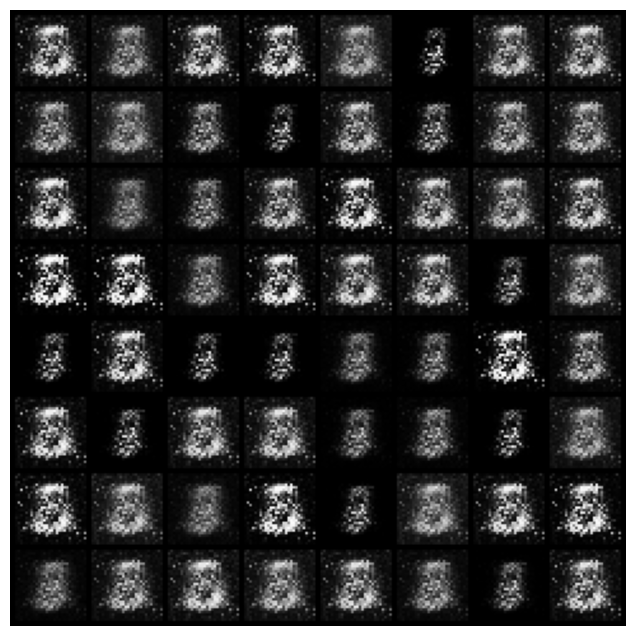

Epoch [6/20], d_loss: 0.1875, g_loss: 5.5303
Epoch [7/20], d_loss: 0.1613, g_loss: 5.9922
Epoch [8/20], d_loss: 0.2001, g_loss: 5.7377
Epoch [9/20], d_loss: 0.3590, g_loss: 3.5738
Epoch [10/20], d_loss: 0.2179, g_loss: 4.5009


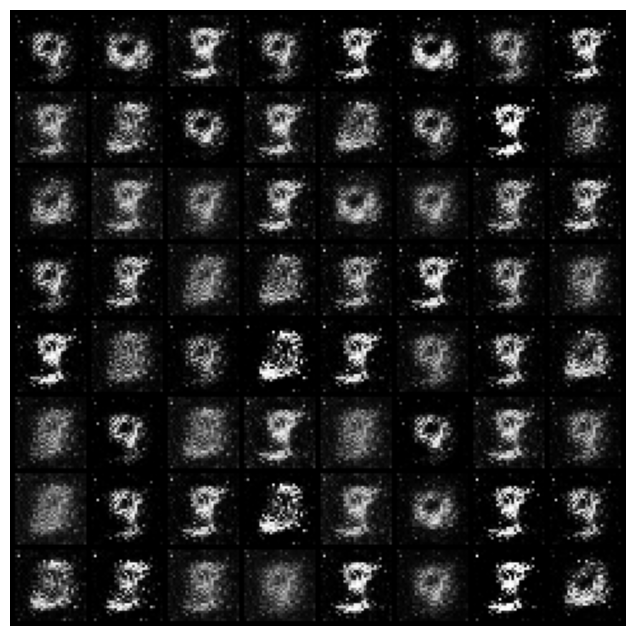

Epoch [11/20], d_loss: 0.3604, g_loss: 4.7462
Epoch [12/20], d_loss: 0.3396, g_loss: 3.9925
Epoch [13/20], d_loss: 0.4509, g_loss: 3.9443
Epoch [14/20], d_loss: 0.4024, g_loss: 4.7727
Epoch [15/20], d_loss: 0.0747, g_loss: 4.7769


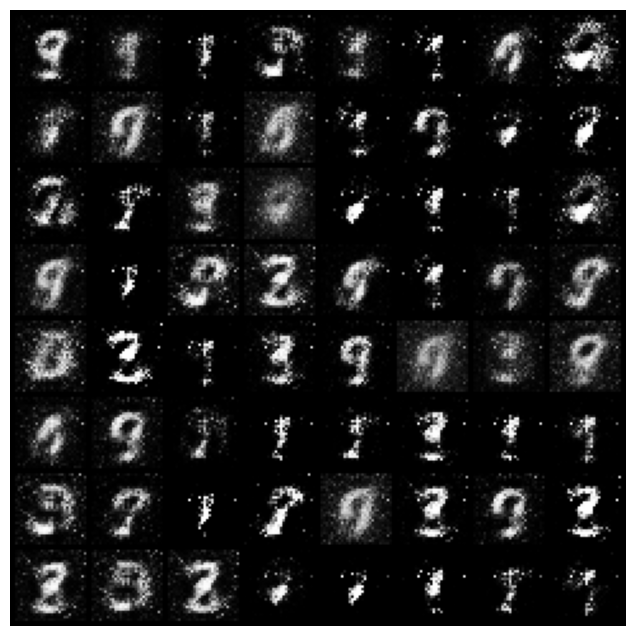

Epoch [16/20], d_loss: 0.3368, g_loss: 5.5333
Epoch [17/20], d_loss: 0.2419, g_loss: 5.5843
Epoch [18/20], d_loss: 0.3180, g_loss: 4.9077
Epoch [19/20], d_loss: 0.2615, g_loss: 6.1355
Epoch [20/20], d_loss: 0.2922, g_loss: 4.2914


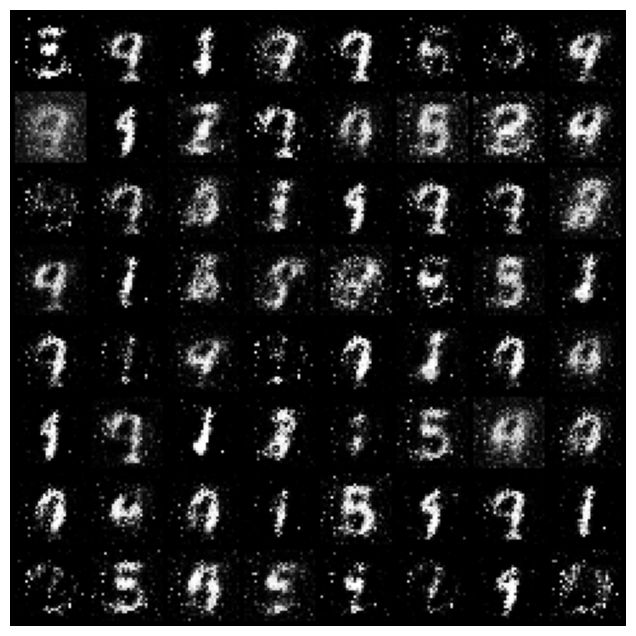

In [9]:
num_epochs = 20 
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        batch_size = imgs.size(0)
        real_imgs = imgs.view(batch_size, -1).to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        outputs = D(real_imgs)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, 100).to(device)
        fake_imgs = G(z)
        outputs = D(fake_imgs.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        optimizerD.zero_grad()
        d_loss.backward()
        optimizerD.step()

        # Train Generator
        outputs = D(fake_imgs)
        g_loss = criterion(outputs, real_labels)  # Generator tries to fool Discriminator

        optimizerG.zero_grad()
        g_loss.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

    # Save and show generated images every 5 epochs
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            z = torch.randn(64, 100).to(device)
            fake_imgs = G(z).view(-1, 1, 28, 28)
            fake_imgs = fake_imgs * 0.5 + 0.5  # Denormalize from [-1,1] to [0,1]
            grid = torchvision.utils.make_grid(fake_imgs, nrow=8)
            plt.figure(figsize=(8,8))
            plt.axis('off')
            plt.imshow(np.transpose(grid.cpu(), (1,2,0)))
            plt.show()